# **Project**: Maze Rider

In [ ]:
#@title Installation
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install chex
!pip install imageio
!pip install gym

from IPython.display import clear_output
clear_output()

In [ ]:
#@title Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import time
import numpy as np
from gym import utils
import enum
from typing import *
import chex

# Environment

For this project, our environment will be a maze. The idea is pretty simple: our agent starts at one end of the maze and must reach a certain goal at the other end. To make things spicier, the agent must also avoid pits scattered in the environment.

At each step the agent can perform one of this four actions: move to the left, to the right, up or down:
- If the agent reaches an empty cell, it gets a reward of $0$.
- If the agent tries to cross a wall, nothing happens and it also gets a reward of $0$.
- If the agent reaches the goal, the episode ends and it gets a reward of $1$.
- If the agent falls into a pit, the episode ends and it gets a reward of $-1$.

The walls will stay the same between each episode, however, the agent's starting position as well as the positions of the goal and the pits will be randomly picked between a small number of candidates at each episode.

In [ ]:
# @title **[Skip]** Environment implementation details

TXT_TEMPLATE = """
#######  #######
# SSS #  #PGGGP#
### ###  ##P P##
  # ######## #
  #          #
  ############
---
S=0
G=0
P=.5
"""

BIG_MAZE = """
#########################################
#SSS#     #PPP#S#      #         #G   PP#
#   #GP       # #####  #P  #     #      #
#   ####  #   # #G     #   #GGGGGGGGG   #
#      GGG#   # #      #   ###########  #
###########         #      #            #
#G        #PP     GGGGGG#GG###S      GGG#
#PP  P#   ##################    #########
#######   #      #P                     #
#G               G      #S      P#      #
#########################################
---
S=0
G=0
P=0.5
"""

class CellType(enum.IntEnum):
  WALL = enum.auto()
  PLAYER = enum.auto()
  GOAL = enum.auto()
  PIT = enum.auto()
  EMPTY = enum.auto()

TYPE_TO_CHAR = {
      CellType.WALL: '#',
      CellType.PLAYER: 'S',
      CellType.GOAL: 'G',
      CellType.PIT: 'P',
      CellType.EMPTY: ' ',
  }

def process_template(txt_template: str) -> Tuple[chex.Array, Mapping[str, float]]:
  char_to_type = {v: k for k, v in TYPE_TO_CHAR.items()}
  maze_template, maze_info = txt_template.split("---")
  grid = maze_template.split('\n')
  grid = [l for l in grid if l]
  n_lines, n_cols = len(grid), max(map(len, grid))
  grid = [l + ' ' * (n_cols - len(l)) for l in grid]
  grid = np.array(list(map(lambda x: list(x), grid)))
  mask_pattern = np.array([' '] * len(CellType))
  for k, v in TYPE_TO_CHAR.items():
    mask_pattern[k.value - 1] = v

  grid = grid[:, :, None] == mask_pattern[None, None]
  maze_infos = [list(map(lambda x: x.strip(' '), x.split('='))) for x in maze_info.split('\n') if x]
  maze_infos = {char_to_type[k]: float(v) for k, v in maze_infos}
  return grid, maze_infos

def sample_grid(grid: chex.Array, maze_infos: Mapping[str, float]) -> chex.Array:
  sample = grid.copy()
  for k, v in maze_infos.items():
    layer = grid[..., k.value - 1]
    if v > 0.:
      mask = np.random.binomial(1, v, size=layer.shape)
      sample[..., k.value - 1] = mask * layer
    else:
      idxs = np.nonzero(layer)
      i = np.random.randint(idxs[0].shape[0])
      sample[..., k.value - 1] = np.zeros_like(sample[..., k.value - 1])
      sample[..., k.value - 1][idxs[0][i], idxs[1][i]] = 1

  # For cells that have no values, fill the space layer with 1
  sample[..., CellType.EMPTY.value - 1] = np.maximum(np.all(sample == 0, axis=-1), sample[..., CellType.EMPTY.value - 1])
  return sample

def to_string(grid: chex.Array) -> str:
  mask_pattern = np.array([' '] * len(CellType))
  for k, v in TYPE_TO_CHAR.items():
    mask_pattern[k.value - 1] = v
  str_grid = mask_pattern[grid.argmax(axis=-1)]
  str_grid = '\n'.join(map(lambda x: ''.join(x), str_grid))
  return str_grid

Read the following definition of the `Maze` environment, so that you get an idea of what you have access to in the environment.

In [ ]:
# @title **[Read]** Environment definition

class Maze:
  """Definition of the Maze environment.

  You do not need to read this class implementation in detail, you should
  just have a look at its different methods, to see what properties of the
  environment you can access.
  """
  def __init__(self, txt_template: str) -> None:
    self._grid_template, self._maze_infos = process_template(txt_template)

  def reset(self) -> chex.Array:
    """Resets the environment."""
    self._grid = sample_grid(self._grid_template, self._maze_infos)
    return self._grid

  def step(self, action: int) -> Tuple[chex.Array, float, bool]:
    """Perfoms one step in the environment.

    Args:
      action: index of the action to perform.
    Returns:
      next_state, reward, done

    next_state: next state of the environment.
    reward: reward of the current step.
    done: if True the game has ended.
    """
    n_rows, n_cols, _ = self._grid.shape
    x, y = np.nonzero(self._grid[..., CellType.PLAYER.value - 1])
    x, y = x[0], y[0]
    next_x, next_y = x, y
    if action == 0:
      next_x = max(min(x + 1, n_rows - 1), 0)
    elif action == 1:
      next_x = max(min(x - 1, n_rows - 1), 0)
    elif action == 2:
      next_y = max(min(y + 1, n_cols - 1), 0)
    elif action == 3:
      next_y = max(min(y - 1, n_cols - 1), 0)
    next_cell_type = CellType(self._grid[next_x, next_y].argmax() + 1)
    if next_cell_type is CellType.WALL:
      next_x, next_y = x, y
      reward = 0.
      done = False
    elif next_cell_type is CellType.EMPTY:
      reward = 0.
      done = False
    elif next_cell_type == CellType.PIT:
      reward = -1.
      done = True
    elif next_cell_type == CellType.GOAL:
      reward = 1.
      done = True
    else:
      raise ValueError(f'Unknown next cell type {next_cell_type}, this should not happen.')
    self._grid[..., CellType.PLAYER.value - 1][x, y] = 0
    self._grid[..., CellType.EMPTY.value - 1][x, y] = 1
    self._grid[..., :][next_x, next_y] = 0
    self._grid[..., CellType.PLAYER.value - 1][next_x, next_y] = 1
    return self._grid, reward, done

  def render(self) -> str:
    """Renders the environment as a string."""
    return to_string(self._grid)

  def num_actions(self) -> int:
    """Returns the number of usable actions."""
    return 4

  def obs_shape(self) -> Tuple[int, int]:
    """Returns the shape of the Maze."""
    return self._grid.shape

Use the following cell to interact manually with the environment: launch it and a small command line will appear. The commands **U**, **D**, **L** and **R** will move the agent `S`, try to reach the goal `G` by hand while avoiding the eventual pits `P`.

If, for some reason, you want to stop the episode before its end just enter **STOP** into the command line.

In [ ]:
#@title **[Play with the environment]**
env = Maze(TXT_TEMPLATE)

env.reset()

action_to_int = {
    'D': 0,
    'U': 1,
    'R': 2,
    'L': 3,
}

# To stop the game, enter this command
STOP_GAME = 'STOP'

while True:
  print(env.render())
  while True:
    action = input().upper()
    if action in ['U', 'D', 'L', 'R', STOP_GAME]:
      break
  if action == STOP_GAME:
    break
  _, reward, done = env.step(action_to_int[action])
  print(f'-----\nReward: {reward}\n-----\n')
  if done:
    break

#######  #######
#  S  #  #PG  P#
### ###  ##   ##
  # ######## #  
  #          #  
  ############  
stop


In [ ]:
print(env.reset())

[[[ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [False False False False  True]
  [False False False False  True]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]
  [ True False False False False]]

 [[ True False False False False]
  [False False False False  True]
  [False  True False False False]
  [False False False False  True]
  [False False False False  True]
  [False False False False  True]
  [ True False False False False]
  [False False False False  True]
  [False False False False  True]
  [ True False False False False]
  [False False False False  True]
  [False False  True False False]
  [False False False False  True]
  [False Fal

# **[Exercice 1]** Implementing a tabular RL Algorithm.

Your first task is to implement a model free tabular RL algorithm for the maze environment. You can go for either Q-learning or SARSA. Feel free to take inspiration from the other practicals.

## Hashing
As in the DQN practical, the environment state is a `chex.Array`, and it can thus not directly be put in a dictionary. As in this practical, you should implement a `numpy_to_hash` function.

This function should transform each state into something that can be used as a key in a dictionary. Additionally, this function should be invertible (each input is uniquely mapped to one unique output). In other word, this function should not lose any information. Think about all the information that are contained in a state (position of the agent, position of the goal, ...) and try to encode them in a hash in a compact way.

Contrary to what was done in the DQN practical, you do not need to implement a `hash_to_numpy` function that is the inverse of `np_to_hash`.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- `def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:` a function that takes in a transition and updates the agent policy.


In [ ]:
from typing import *

def numpy_to_hash(state : chex.Array) -> Tuple[int, int, int, int]:
    """
    This solution is a part of the last practical on hash function
    """

    state = state.argmax(axis = -1)
    X2, Y2 = np.where(state==2)
    X1, Y1 = np.where(state==1)
    X3, Y3 = np.where(state == 3)
    return tuple((x,y,1) for x,y in zip(X1,Y1)) + tuple( (x,y,2) for x,y in zip(X2,Y2)) + tuple( (x,y,3) for x,y in zip(X3,Y3))

In [ ]:
# @title **[Implement]** Q-learning { form-width: "30%" }


class QAgent:
    """Q-learning with epsilon-greedy exploration."""
    def __init__(self, env: env, gamma: float, alpha: float):
      self.qfunction = {}
      self._env = env
      self._Na = env.num_actions()
      self._alpha = alpha
      self._gamma = gamma


    def act(self, state: chex.Array, eval: bool = False) -> int:
      hash = numpy_to_hash(state)
      if hash not in self.qfunction:
        self.qfunction[hash] = np.zeros((self._Na,))

      argmax_action = np.argmax(self.qfunction[hash])
      u = np.random.uniform()
      if not eval:
        return np.random.randint(self._Na)
      return argmax_action

    def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:
      hash = numpy_to_hash(state)
      if hash not in self.qfunction:
        self.qfunction[hash] = np.zeros((self._Na,))
      if done:
        self.qfunction[hash][action] += self._alpha * (reward - self.qfunction[hash][action])
        return
      if not done:
        next_hash = numpy_to_hash(next_state)
        if next_hash not in self.qfunction:
          self.qfunction[next_hash] = np.zeros((self._Na,))
        self.qfunction[hash][action] += self._alpha * (reward + self._gamma * self.qfunction[next_hash].max() - self.qfunction[hash][action])

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	5	|	0.0
	10	|	0.0
	15	|	0.0
	20	|	0.0
	25	|	0.0
	30	|	0.0
	35	|	0.0
	40	|	0.0
	45	|	0.0
	50	|	0.0
	55	|	0.0
	60	|	0.0
	65	|	0.0
	70	|	0.0
	75	|	0.0
	80	|	0.0
	85	|	0.0
	90	|	0.0
	95	|	0.0
	100	|	0.0
	105	|	0.0
	110	|	0.0
	115	|	0.0
	120	|	0.0
	125	|	0.1
	130	|	0.2
	135	|	0.0
	140	|	0.0
	145	|	0.1
	150	|	0.3
	155	|	0.0
	160	|	0.0
	165	|	0.0
	170	|	0.0
	175	|	0.0
	180	|	0.0
	185	|	0.1
	190	|	0.2
	195	|	0.2
	200	|	0.0
	205	|	0.0
	210	|	0.2
	215	|	0.1
	220	|	0.1
	225	|	0.1
	230	|	0.2
	235	|	0.3
	240	|	0.0
	245	|	0.2
	250	|	0.0
	255	|	0.0
	260	|	0.0
	265	|	0.1
	270	|	0.5
	275	|	0.4
	280	|	0.3
	285	|	0.2
	290	|	0.3
	295	|	0.0
	300	|	0.3
	305	|	0.1
	310	|	0.2
	315	|	0.3
	320	|	0.2
	325	|	0.4
	330	|	0.5
	335	|	0.3
	340	|	0.4
	345	|	0.2
	350	|	0.3
	355	|	0.1
	360	|	0.1
	365	|	0.3
	370	|	0.1
	375	|	0.3
	380	|	0.3
	385	|	0.5
	390	|	0.5
	395	|	0.1
	400	|	0.5
	405	|	0.4
	410	|	0.3


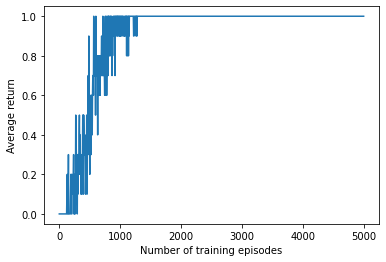

In [ ]:
# @title **[Fill]** Run your agent
import matplotlib.pyplot as plt

num_episodes = 5000
num_eval_episodes = 10
eval_every_N = 5
alpha = .03
gamma = .9


environment = Maze(TXT_TEMPLATE)
Na = environment.num_actions

# [DEFINE YOUR AGENT HERE]
agent = QAgent(environment, gamma, alpha)
all_rewards = []
episodes = []

def run_episode(agent: QAgent, env: Maze, eval: bool, max_steps: int = 1000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)
    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, eval=False)

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

In [ ]:
# @title **[Run]** Visualize one trajectory for your agent.
run_episode(agent, environment, eval=True, render=True)

Step: 0
#######  #######
#  S  #  #P G  #
### ###  ##  P##
  # ######## #  
  #          #  
  ############  
Step: 1
#######  #######
#     #  #P G  #
###S###  ##  P##
  # ######## #  
  #          #  
  ############  
Step: 2
#######  #######
#     #  #P G  #
### ###  ##  P##
  #S######## #  
  #          #  
  ############  
Step: 3
#######  #######
#     #  #P G  #
### ###  ##  P##
  # ######## #  
  #S         #  
  ############  
Step: 4
#######  #######
#     #  #P G  #
### ###  ##  P##
  # ######## #  
  # S        #  
  ############  
Step: 5
#######  #######
#     #  #P G  #
### ###  ##  P##
  # ######## #  
  #  S       #  
  ############  
Step: 6
#######  #######
#     #  #P G  #
### ###  ##  P##
  # ######## #  
  #   S      #  
  ############  
Step: 7
#######  #######
#     #  #P G  #
### ###  ##  P##
  # ######## #  
  #    S     #  
  ############  
Step: 8
#######  #######
#     #  #P G  #
### ###  ##  P##
  # ######## #  
  #     S    #  
  ############  
Step: 9
##

1.0

# **[Exercice 2]** Implementing a deep RL Algorithm.

Your second (harder) task is to implement a _Deep RL algorithm_ for the maze environment. You can go for either DQN or a variant of policy gradient of your choice. Again, feel free to take inspiration from the other practicals.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- ` def first_observe(self, state: chex.Array) -> None:` a function that takes care of handling the first observation obtained after a reset. This function can notably memorize the first state, so that when we call observe, we have a full transition `(state, action, reward, done, next_state)` at our disposal.
- `def observe(self, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array) -> chex.Array:` a function that takes an action, a reward, a termination signal and a next state, and performs any update required by our agent to update its policy. To make things much easier, you should look at what this function is doing for the implementation in the DQN practical.

In [ ]:
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import haiku as hk
import io
import itertools

In [ ]:
# Inspiration from code in DQN practical

#@title **[Implement]** Uniform Replay Buffer { form-width: "30%" }

import dataclasses

@chex.dataclass
class Transition:
  state_t: chex.Array
  action_t: chex.Array
  reward_t: chex.Array
  done_t: chex.Array
  state_tp1: chex.Array


class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          batch_size (int): size of each training batch
      """
      self._memory = list()
      self._maxlen = buffer_capacity

  def size(self) -> int:
    return len(self._memory)

  def add(self, state_t: chex.Array, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array):
      """Add a new transition to memory."""
      if len(self._memory) >= self._maxlen:
        self._memory.pop(0)  # remove first elem (oldest)

      transition = Transition(
          state_t=state_t, action_t=action_t, reward_t=reward_t, done_t=done_t, state_tp1=state_tp1)

      # convert every data into jnp array
      transition = jax.tree_map(jnp.array, transition)

      self._memory.append(transition)

  def sample(self) -> Transition:
      """Randomly sample a transition from memory."""
      assert self._memory, 'replay buffer is unfilled'
      transition_idx = np.random.randint(0, len(self._memory))
      transition = self._memory[transition_idx]

      return transition


In [ ]:
#@title **[Implement]** Uniform Replay Buffer with Batch{ form-width: "30%" }

class BatchedReplayBuffer(ReplayBuffer):

  def sample_batch(self, batch_size) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'
    idxs = np.random.randint(0, len(self._memory), (batch_size,))
    transitions = [self._memory[i] for i in idxs]
    return jax.tree_map(lambda *x: np.stack(x), *transitions)

In [ ]:
environment = Maze(TXT_TEMPLATE)
INDEX_TO_CHANNEL = {'WALL' : 0,
                    'PLAYER': 1,
                    'GOAL': 2,
                    'PIT': 3,
                    'EMPTY': 4}

In [ ]:
#@title **[Implement]** Maze Network { form-width: "30%" }
def Maze_network(x: chex.Array, env: Maze, c1: int=32, c2: int=64, f: int=128):
  # Add a channel dimension, since catch observations are spatial 5 x 5
  # from DQN practical
  x = x.astype(float)[..., None]
  model = hk.Sequential([
      hk.Conv3D(c1, kernel_shape=[3, 3, 3], stride=2, padding='SAME'),
      jax.nn.relu,
      hk.Conv3D(c2, kernel_shape=[2, 2, 2], stride=1, padding='SAME'),
      jax.nn.relu,
      hk.Flatten(),
      hk.nets.MLP([f, environment.num_actions()])
  ])
  return model(x)

In [ ]:
# @title **[Implement]** Define our agent

@chex.dataclass
class LearnerState:
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DeepAgent:

  def __init__(
      self,
      env: env,
      gamma: float,
      eps: float,
      learning_rate: float,
      buffer_capacity: int,
      min_buffer_capacity: int,
      batch_size: int,
      target_ema: float,
      seed: int = 0,
      ) -> None:
    self._env = env
    self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_qfunction))
    self.apply = jax.jit(self._apply)
    self._learning_rate = learning_rate
    self._gamma = gamma
    self._eps = eps
    self._Na = env.num_actions()
    self._buffer = BatchedReplayBuffer(buffer_capacity)
    self._state = None
    self._rng = jax.random.PRNGKey(seed)
    self._rng, init_rng = jax.random.split(self._rng)
    self._learner_state = self._init_state(init_rng)
    self._min_buffer_capacity = min_buffer_capacity
    self._batch_size = batch_size
    self._target_ema = target_ema
    self._update_fn = jax.jit(self._update_fn)
    self.occ_map = {}

  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    dummy_step = self._env.reset()
    online_params = self._init(rng, dummy_step[None].astype(float))
    target_params = online_params
    opt_state = self._optimizer().init(online_params)
    return LearnerState(online_params=online_params, target_params=target_params, opt_state=opt_state)

  def act(self, state: chex.Array, eval: bool) -> chex.Array:
    self._rng, *rngs = jax.random.split(self._rng, 4)
    qs = self.apply(self._learner_state.online_params, state[None])
    u = jax.random.uniform(rngs[0])
    action = jnp.argmax(qs, axis=-1)[0]
    if u < self._eps and not eval:
      action = jax.random.randint(rngs[1], (), 0, self._Na)

    # Add state, action to occupation map
    hash = numpy_to_hash(state)
    if hash not in self.occ_map:
      self.occ_map[hash] = np.zeros((self._Na,))
    self.occ_map[hash][action] += 1
    return action

  def _update_fn(self, state: LearnerState, batch: Transition) -> Tuple[chex.Array, LearnerState]:
    online_params = state.online_params
    target_params = state.target_params
    opt_state = state.opt_state

    # Compute gradient
    loss, gradients = jax.value_and_grad(self.loss_fn)(online_params, target_params, batch.state_t, batch.action_t, batch.reward_t, batch.done_t, batch.state_tp1)

    # Apply gradients
    updates, new_opt_state = self._optimizer().update(gradients, opt_state)
    new_online_params = optax.apply_updates(online_params, updates)

    # Update target network
    new_target_params = jax.tree_map(lambda x, y: x + (1 - self._target_ema) * (y - x),
                                      target_params, new_online_params)

    return loss, LearnerState(online_params=new_online_params, target_params=new_target_params, opt_state=new_opt_state)

  def first_observe(self, state: chex.Array) -> None:
    self._state = state

  def observe(self, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array) -> chex.Array:
    self._buffer.add(self._state, action_t, reward_t, done_t, state_tp1)
    self._state = state_tp1
    if self._buffer.size() >= self._min_buffer_capacity:
      batch = self._buffer.sample_batch(self._batch_size)
      loss, self._learner_state = self._update_fn(self._learner_state, batch)
      return loss
    return 0.

  def loss_fn(
      self,
      online_params: hk.Params,
      target_params: hk.Params,
      state_t: chex.Array,
      action_t: chex.Array,
      reward_t: chex.Array,
      done_t: chex.Array,
      state_tp1: chex.Array,
      ) -> chex.Array:

      ### Compute the target y_tp1
      # Extimate q_tp1 with target network without propagating the gradient
      q_tp1 = self._apply(target_params, state_tp1)
      q_tp1 = jax.lax.stop_gradient(q_tp1)

      # Do not bootstrap q-values at the end of the trajectory
      q_tp1 = (1. - done_t[..., None]) * q_tp1

      # compute the target y_t
      y_t = reward_t + gamma * jnp.max(q_tp1, axis=-1)

      ### Compute the estimate qa_t

      # Estimate q_tm1 with the online network
      q_t = self._apply(online_params, state_t)

      # Perform batch indexing to obtain q_tm1(ob_tm1, a_tm1)
      qa_t = jax.vmap(lambda q, a: q[a])(q_t, action_t)

      ### Compute the final loss

      # Compute the final loss
      td_error = y_t - qa_t

      # Compute the L2 error in expectation
      q_loss = 0.5 * jnp.square(td_error)
      q_loss = jnp.mean(q_loss)

      return q_loss

  def _hk_qfunction(self, state: chex.Array) -> chex.Array:
    return Maze_network(state, self._env)

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Episode number:	| Average reward on 3 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.6666666666666666
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.6666666666666666
	80	|	1.0
	90	|	0.0
	100	|	0.0
	110	|	1.0
	120	|	0.0
	130	|	1.0
	140	|	0.6666666666666666
	150	|	0.3333333333333333
	160	|	1.0
	170	|	1.0
	180	|	1.0
	190	|	0.3333333333333333
	200	|	1.0
	210	|	0.6666666666666666
	220	|	0.6666666666666666
	230	|	1.0
	240	|	1.0
	250	|	1.0
	260	|	0.3333333333333333
	270	|	1.0
	280	|	1.0
	290	|	1.0
	300	|	1.0
	310	|	1.0
	320	|	1.0
	330	|	1.0
	340	|	1.0
	350	|	1.0
	360	|	1.0
	370	|	1.0
	380	|	1.0
	390	|	1.0
	400	|	1.0
	410	|	1.0
	420	|	0.6666666666666666
	430	|	1.0
	440	|	1.0
	450	|	1.0
	460	|	1.0
	470	|	1.0
	480	|	1.0
	490	|	1.0
	500	|	1.0
	510	|	1.0
	520	|	1.0
	530	|	1.0
	540	|	1.0
	550	|	1.0
	560	|	1.0
	570	|	1.0
	580	|	1.0
	590	|	1.0
	600	|	1.0
	610	|	1.0
	620	|	1.0
	630	|	1.0
	640	|	1.0
	650	|	0.6666666666666666
	660	|	0.6666666666666666
	6

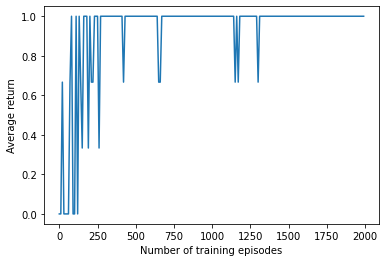

In [ ]:
#@title **[Fill]** Run your deep RL Algorithm { form-width: "30%" }

num_episodes = 2000#@param
num_eval_episodes = 3#@param
eval_every_N = 10#@param
gamma=.9#@param
learning_rate=3e-4#@param
eps = .3#@param
buffer_capacity=1000#@param
min_buffer_capacity=32#@param
batch_size=32#@param
target_ema=.9#@param
env = Maze(TXT_TEMPLATE)

deep_agent = DeepAgent(env=env, gamma=.9,
                       learning_rate=3e-4,
                       eps = .3,
                       buffer_capacity=1000,
                       min_buffer_capacity=32,
                       batch_size=32,
                       target_ema=.9,
) # Fill with your agent here

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = 1000) -> float:
  # Reset any counts and start the environment.
  state = environment.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  # Run an episode.
  while True:

    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = environment.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, environment, eval=False)

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, environment, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)